In [5]:
import cv2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json

In [2]:
from skimage.transform import resize
import sqlite3

df = pd.read_csv('data/Challenge2.csv')

# create column names for dataframe and database table
cols = "depth, "
for i in range(1, 151):
    cols += f'col{i},'

df_final = pd.DataFrame(columns=cols.rstrip(cols[-1]).split(','))

for idx, row in df.iterrows():
    # resize the 200 columns to 150 columns using skimage
    bottle_resized = resize(row[1:-1], (150, 150))[0].tolist()
    bottle_resized.insert(0, row['depth'])
    #write to dataframe
    df_final.loc[idx] = bottle_resized

# Connect to the SQLite database
conn = sqlite3.connect('challenge2.db')
c = conn.cursor()

# write data to sqlite3 datatable (challenge2)
df_final.to_sql('challenge2', conn, if_exists='append', index=False)

# Commit changes and close the connection
conn.commit()
conn.close()

/Users/manojkumar/vscode/assignment/venv/lib/python3.10/site-packages/skimage/transform/_warps.py:738: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/Users/manojkumar/vscode/assignment/venv/lib/python3.10/site-packages/skimage/transform/_warps.py:742: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


/var/folders/ry/d4qsh73n1qs_3n8ndgjts_5c0000gn/T/ipykernel_61829/1748057479.py:5: RuntimeWarning: invalid value encountered in cast
  data = ((data - data.min()) / (data.max() - data.min()) * 255).astype(np.uint8)


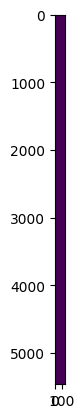

In [3]:
# Convert dataframe to a NumPy array
data = df_final.values

# Normalize the data to fit within the range [0, 255]
data = ((data - data.min()) / (data.max() - data.min()) * 255).astype(np.uint8)

# Reshape the data into a 2D array representing the image
image_data = np.reshape(data, (data.shape[0], data.shape[1], 1))

# Load the image using OpenCV
image = cv2.resize(image_data, (data.shape[1], data.shape[0]))  # Resize to original shape
plt.imshow(image)

In [20]:
with open('data/_annotations.coco.json', 'r') as f:
    file = json.load(f)

images = file['images']
annotations = file['annotations']

In [11]:
img = cv2.imread('data/coin-dataset/8ea74b64-c9a5-4caf-9e0b-e659b748632b_jpg.rf.db1b105879caa0d18eaf1ca6fab1b2da.jpg')
arr = np.array(img)
arr.shape

(956, 1300, 3)

In [34]:
for i, image in enumerate(images):
    # Load the image
    path = f"data/coin-dataset/{image['file_name']}"
    print(path)
    img = cv2.imread(path)
    
    # Loop through each coin information
    for j, coin in enumerate(annotations):
        # Extract boundary box coordinates
        print(coin['bbox'][0], coin['bbox'][1], coin['bbox'][2], coin['bbox'][3])
        x, y, w, h = coin['bbox']
        
        # Extract the coin region from the original image
        coin_region = img[y:y+h, x:x+w]

        if coin_region.size > 0:
            # Save the extracted coin as a new image
            plt.imsave(f'data/test/coin_{j+1}.jpg', coin_region)

data/coin-dataset/download--95-_jpg.rf.01518d3a04efa6c09f8e2adfb937983c.jpg
67 83 72 71
185 75 86 86
85 65 365 285
521 201 680 687
199 164 50 47
264 141 50 44
558 16 65 63
264 219 75 73
299 107 75 74
553 144 71 69
518 339 67 62
290 309 74 71
402 193 71 66
210 147 73 68
400 13 82 83
412 369 67 63
530 245 65 64
403 292 65 64
412 107 70 67
175 297 77 74
229 1092 365 364
1413 1086 388 388
1166 631 398 382
834 1093 394 395
453 594 409 424
217 152 66 63
232 69 69 64
223 160 79 78
152 100 69 64
178 160 67 66
169 355 191 190
180 134 137 70
213 86 102 99
163 166 64 63
222 99 57 60
115 237 57 56
299 210 58 56
317 117 67 70
227 155 77 81
119 110 78 78
78 80 70 71
269 128 81 78
220 53 74 72
175 151 104 94
207 111 104 80
159 164 284 277
372 259 105 102
53 250 100 102
166 249 100 103
268 253 101 102
467 306 107 105
165 362 101 102
275 353 103 105
379 369 105 103
45 354 102 103
312 141 67 65
191 108 57 50
81 95 86 89
155 83 105 105
266 74 105 105
410 206 455 451
788 347 681 626
134 457 565 528
221 47

KeyboardInterrupt: 

In [50]:
def convert_to_yolo_format(x_min, y_min, x_max, y_max, image_width, image_height, class_id):
    """
    Converts bounding box coordinates to YOLO format.
    
    Args:
        x_min (float): Leftmost x-coordinate of the bounding box.
        y_min (float): Topmost y-coordinate of the bounding box.
        x_max (float): Rightmost x-coordinate of the bounding box.
        y_max (float): Bottommost y-coordinate of the bounding box.
        image_width (float): Width of the image.
        image_height (float): Height of the image.
        class_id (int): Class ID of the object.
        
    Returns:
        list: YOLO format representation of the bounding box [class_id, x_center_normalized, y_center_normalized, width_normalized, height_normalized].
    """
    
    # Calculate the width and height of the bounding box
    width = x_max - x_min
    height = y_max - y_min
    
    # Calculate the center coordinates of the bounding box
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    
    # Normalize the center coordinates and the width and height
    x_center_normalized = x_center / image_width
    y_center_normalized = y_center / image_height
    width_normalized = width / image_width
    height_normalized = height / image_height
    
    # Create the YOLO format representation
    yolo_format = [int(class_id), x_center_normalized, y_center_normalized, width_normalized, height_normalized]
    
    return yolo_format

In [54]:
import cv2
import os

def get_bboxes(input_dir, file_name, output_dir):
    path = os.path.join(input_dir, file_name)
    image = cv2.imread(path)
    image = cv2.medianBlur(image,5)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    blur = cv2.GaussianBlur(gray, (7, 7), 3)
    # Detect circles using the Hough Circle Transform
    circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=10, maxRadius=100)
    circles = circles[0,:]

    df_bboxes = pd.DataFrame(columns=['class', 'xmin', 'ymin', 'xmax', 'ymax'])
    for i, circle in enumerate(circles):
        x, y, r = circle.astype(int)
        if x > 200 and y > 150:
            # Extract the coin from the image
            # converted =convert_bboxes_to_yolo([y - r, y + r, x - r, x + r], img_copy.shape[1], img_copy.shape[0])
            x_min = y - r
            y_min = y + r
            x_max = x - r
            y_max = x + r
            image_width = img.shape[1]
            image_height = img.shape[0]
            class_id = 0
            
            yolo_format = convert_to_yolo_format(x_min, y_min, x_max, y_max, image_width, image_height, class_id)
            print(yolo_format) 

            df_bboxes.loc[len(df_bboxes)] = yolo_format
            df_bboxes['class'] = df_bboxes['class'].astype('int')
            
    file = os.path.join(output_dir, file_name.replace('.jpg', '.txt')) 
    df_bboxes.to_csv(file, index=False, header=False, sep=' ')


# Directory containing the input images
input_dir = "data/coin-dataset/train/images"
# Directory to save the extracted coins
output_dir = "data/coin-dataset/train/labels"
# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Loop over the input images
for filename in os.listdir(input_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(input_dir, filename)
        print(image_path)
        get_bboxes(input_dir, filename, output_dir)

data/coin-dataset/train/images/DSC_0836_1561593693_jpg.rf.34495d500171063cdaab95589d623345.jpg
[0, 0.2546875, 0.7520833333333333, 0.225, 0.3]
[0, 0.2265625, 0.7145833333333333, 0.221875, 0.29583333333333334]
[0, 0.21796875, 0.703125, 0.0078125, 0.010416666666666666]
[0, 0.30546875, 0.7447916666666666, 0.1265625, 0.16875]
[0, 0.27265625, 0.709375, 0.2765625, 0.36875]
[0, 0.2421875, 0.6479166666666667, -0.0375, -0.05]
[0, 0.2890625, 0.6520833333333333, -0.053125, -0.07083333333333333]
[0, 0.309375, 0.7416666666666667, 0.225, 0.3]
[0, 0.38359375, 0.7364583333333333, 0.1828125, 0.24375]
[0, 0.34921875, 0.8447916666666667, -0.0328125, -0.04375]
[0, 0.315625, 0.7083333333333334, 0.06875, 0.09166666666666666]
[0, 0.25625, 0.5791666666666667, 0.090625, 0.12083333333333333]
[0, 0.29921875, 0.615625, -0.1078125, -0.14375]
[0, 0.36015625, 0.734375, 0.1296875, 0.17291666666666666]
[0, 0.29765625, 0.5510416666666667, -0.0796875, -0.10625]
[0, 0.29921875, 0.6239583333333333, 0.0515625, 0.06875]
[0, 

In [16]:
df_bboxes

,class,xmin,ymin,xmax,ymax
0,0,91,289,235,433
1,0,74,272,216,414
2,0,137,335,142,340
3,0,155,317,236,398
4,0,86,252,263,429
5,0,167,323,143,299
6,0,202,330,168,296
7,0,126,284,270,428
8,0,187,295,304,412
9,0,234,416,213,395


In [6]:
import cv2
import os

# Function to extract coins from an image
def extract_coins(image_path, output_dir, id):
    # Load the image
    image = cv2.imread(image_path)
    
    # img = cv2.medianBlur(image,11)
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    blur = cv2.GaussianBlur(gray, (7, 7), 3)
    # Detect circles using the Hough Circle Transform
    circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=10, maxRadius=100)

    # If circles are detected
    if circles is not None:
        circles = circles[0, :]
        
        # Loop over the detected circles
        for i, circle in enumerate(circles):
            x, y, r = circle.astype(int)
            if x > 200 and y > 150:
                # Extract the coin from the image
                coin = image[y - r:y + r, x - r:x + r]
                
                # Save the coin as an image file
                coin_filename = os.path.join(output_dir, f"coin_{i}_id_{id}.jpg")
                plt.imsave(coin_filename, coin)
            
    else:
        print(f"No coins detected in {image_path}")

# Directory containing the input images
input_dir = "data/coin-dataset"

# Directory to save the extracted coins
output_dir = "data/test"

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Loop over the input images
# for filename in os.listdir(input_dir):
for i, image in enumerate(images):
    if image['file_name'].endswith(".jpg") or image['file_name'].endswith(".png"):
        image_path = os.path.join(input_dir, image['file_name'])
        print(image_path)
        extract_coins(image_path, output_dir, image['id'])

data/coin-dataset/download--95-_jpg.rf.01518d3a04efa6c09f8e2adfb937983c.jpg
data/coin-dataset/20190619_085307_jpg.rf.017b6a6dc75d86c67a8805b01c8d8b6e.jpg
data/coin-dataset/19687092-68a2-495f-a349-4069409a5d29_jpg.rf.02f9c4ad91747ca769e068a522cf9519.jpg
data/coin-dataset/abe16773-2d0b-495d-80e2-215f30d58074_jpg.rf.06495d5cdfbe85fcb35a2f9e0d4f3e70.jpg
data/coin-dataset/DSC_0861_jpg.rf.06541e532265c745a5201987f777c5a1.jpg
data/coin-dataset/175_1479423456_jpg.rf.0723ceef6a241da65f4f36db2132002b.jpg
data/coin-dataset/831ab469-f783-4cd1-9b10-649c374cbf11_jpg.rf.084159eeadebbd4f6ba1bb3030cca281.jpg
data/coin-dataset/DSC_0835_jpg.rf.0862b41604078599b999940cb2860520.jpg
data/coin-dataset/DSC_2643_1561679976_jpg.rf.08e8cdb835c57e63099f04c7fa8b94d9.jpg
data/coin-dataset/DSC_0818_jpg.rf.0aaa4a9563aca5dd96fd7e97f94d718b.jpg
data/coin-dataset/cc5f8d64-26a6-4215-ae96-edb2a15711dd_jpg.rf.0c76bab9c3001630a572683d06e04df4.jpg
data/coin-dataset/DSC_0798_jpg.rf.0ca7c11603bdef5b0318b99a22f0e177.jpg
data/co

In [22]:
import cv2
import os

# Function to extract coins from an image
def extract_coins(image_path, output_dir):
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Detect circles using the Hough Circle Transform
    circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=10, maxRadius=100)
    
    # If circles are detected
    if circles is not None:
        print(circles)
        circles = circles[0, :]
        
        # Loop over the detected circles
        for i, circle in enumerate(circles):
            x, y, r = circle.astype(int)
            # if x > 250 and y > 250:
            # Extract the coin from the image
            coin = image[y - r:y + r, x - r:x + r]
            
            # Save the coin as an image file
            coin_filename = os.path.join(output_dir, f"coin_{os.path.basename(image_path).split('.')[0]}_{i}.png")
            cv2.imwrite(coin_filename, coin)
            
    else:
        print(f"No coins detected in {image_path}")

# Directory containing the input images
input_dir = "data/coin-dataset"

# Directory to save the extracted coins
output_dir = "data/test"

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Loop over the input images
for filename in os.listdir(input_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(input_dir, filename)
        extract_coins(image_path, output_dir)

[[[245.5 225.5  91.7]
  [243.5 137.5  92.8]
  [287.5 143.5  95. ]
  [311.5 130.5  99.4]
  [260.5 102.5  99.4]
  [267.5 128.5  99.4]
  [133.5 202.5  77.4]
  [184.5 192.5  78.5]
  [317.5 106.5  99.4]
  [280.5 107.5  99.4]
  [253.5 206.5  71.9]
  [235.5 191.5  73. ]
  [390.5 116.5  89.5]
  [124.5 126.5  64.2]
  [325.5 226.5  62. ]
  [161.5 201.5  69.7]
  [410.5  99.5  99.4]
  [187.5 214.5  69.7]
  [370.5 101.5  99.4]
  [300.5  94.5  93.9]
  [141.5  78.5  74.1]
  [234.5 101.5  85.1]
  [137.5 104.5  62. ]
  [304.5 217.5  62. ]
  [270.5  84.5  82.9]
  [347.5 107.5  97.2]
  [227.5 169.5  59.8]
  [247.5 170.5  62. ]
  [ 97.5 212.5  64.1]
  [429.5 115.5  79.6]
  [334.5 135.5  69.7]
  [265.5 223.5  63.1]
  [148.5 130.5  47.7]
  [147.5 219.5  62. ]
  [358.5 131.5  81.8]
  [423.5 220.5  55.4]
  [108.5 161.5  53.2]
  [ 96.5 137.5  49.9]
  [211.5 209.5  62. ]
  [103.5 109.5  49.9]
  [413.5 274.5  93.9]
  [333.5 248.5  47.7]
  [407.5 187.5  47.7]
  [120.5 218.5  59.8]
  [400.5 210.5  49.9]
  [355.5 2

error: OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:786: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


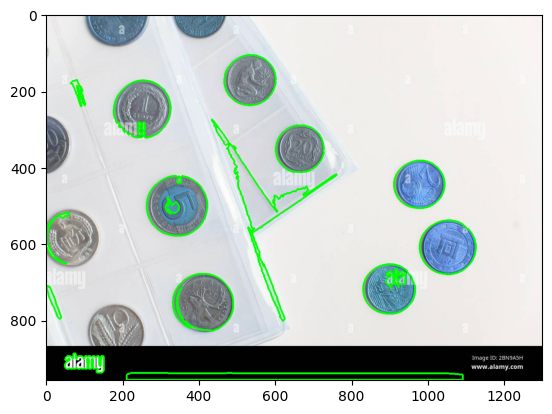

In [16]:
blur = cv2.GaussianBlur(img, (7, 7), 1)
gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
if int(ret) % 2 ==0:
    ret = int(ret) + 1
thresh2 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, int(ret), 5)
contours, _ = cv2.findContours(thresh2, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
i = img_copy

area = {}

for val in range(len(contours)):
    cnt = contours[val]
    ar = cv2.contourArea(cnt)
    area[val] = ar
srt = sorted(area.items(), key= lambda x: x[1], reverse=True)
results = np.array(srt).astype('int')
num = np.argwhere(results[: ,1] > 500).shape[0]

for val in range(1, num):
    i = cv2.drawContours(i, contours, results[val, 0], (0, 255, 0), 3)

plt.imshow(i)

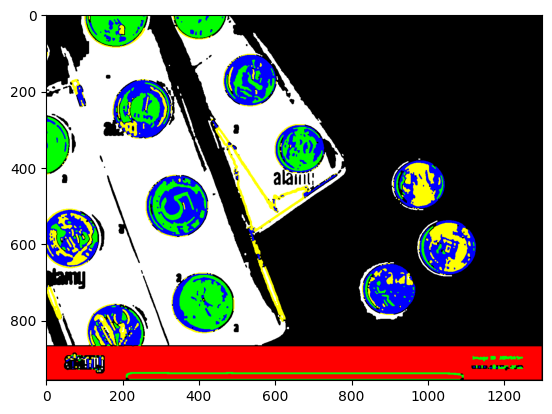

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_multiotsu
from scipy import ndimage as nd

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray, (9, 9), 0)

# Perform thresholding using multi-Otsu method
thresholds = threshold_multiotsu(blurred, classes=6)  # Adjust the number of classes as needed

# Generate binary image based on thresholds
binary = np.digitize(blurred, bins=thresholds)

seg1 = (binary == 0)
seg2 = (binary == 1)
seg3 = (binary == 2)
seg4 = (binary == 3)
seg5 = (binary == 4)
seg6 = (binary == 5)

seg1_opening = nd.binary_opening(seg1, np.ones((3, 3)))
seg1_closing= nd.binary_closing(seg1_opening, np.ones((3, 3)))

seg2_opening = nd.binary_opening(seg2, np.ones((3, 3)))
seg2_closing= nd.binary_closing(seg2_opening, np.ones((3, 3)))

seg3_opening = nd.binary_opening(seg3, np.ones((3, 3)))
seg3_closing= nd.binary_closing(seg3_opening, np.ones((3, 3)))

seg4_opening = nd.binary_opening(seg4, np.ones((3, 3)))
seg4_closing= nd.binary_closing(seg4_opening, np.ones((3, 3)))

seg5_opening = nd.binary_opening(seg5, np.ones((3, 3)))
seg5_closing= nd.binary_closing(seg5_opening, np.ones((3, 3)))

all_segments_cleaned = np.zeros((img.shape[0], img.shape[1], 3))
all_segments_cleaned[seg1_closing] = (1, 0, 0)
all_segments_cleaned[seg2_closing] = (0, 1, 0)
all_segments_cleaned[seg3_closing] = (0, 0, 1)
all_segments_cleaned[seg4_closing] = (1, 1, 0)
all_segments_cleaned[seg5_closing] = (1, 1, 1)

plt.imshow(all_segments_cleaned)

In [6]:
def detect_coins(image, file_name):
    blur = cv2.GaussianBlur(image, (9, 9), 3)
    gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    if int(ret) % 2 ==0:
        ret = int(ret) + 1
    thresh2 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, int(ret), 5)
    contours, _ = cv2.findContours(thresh2, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    img_copy = image
    
    area = {}
    for val in range(len(contours)):
        cnt = contours[val]
        ar = cv2.contourArea(cnt)
        area[val] = ar
    srt = sorted(area.items(), key= lambda x: x[1], reverse=True)
    results = np.array(srt).astype('int')
    num = np.argwhere(results[: ,1] > 500).shape[0]

    for val in range(1, num):
        img_copy = cv2.drawContours(img_copy, contours, results[val, 0], (0, 255, 0), 3)

    plt.imsave(f"/Users/manojkumar/vscode/assignment/data/labeled-dataset/{file_name}", img_copy)

In [8]:
import os

# Assign directory
directory = r"data/coin-dataset/"
 
# Iterate over files in directory
for name in os.listdir(directory):
    print(directory + name)
    img = cv2.imread(directory + name)
    detect_coins(img, name)
    del img

data/coin-dataset/DSC_0836_1561593693_jpg.rf.34495d500171063cdaab95589d623345.jpg
data/coin-dataset/a45f5038-0a82-4bc0-9433-acbe92156007_jpg.rf.716a2313002d574cd0a6014b86775df4.jpg
data/coin-dataset/150_1479430338_jpg.rf.d707b93a1030d6b1e73ada2bbaa676de.jpg
data/coin-dataset/download--66-_jpg.rf.4039d67d4633416a1f9c491836f3a3e2.jpg
data/coin-dataset/DSC_2646_1561679976_jpg.rf.e03be81a3799675ffa8a79d7dbcab656.jpg
data/coin-dataset/DSC_0377_jpg.rf.15e701e1139960623cf83bd29ae1bf9a.jpg
data/coin-dataset/DSC_0378_2_jpg.rf.68f1706e7b9a449a27fdc1d83e802341.jpg
data/coin-dataset/5_1477145520_jpg.rf.482c996bea54317e55a68c1c99eb1295.jpg
data/coin-dataset/a44992d2-073a-4906-bf42-a053ba68b93c_jpg.rf.168d83186160b6c260234524f449fb98.jpg
data/coin-dataset/175_1479423456_jpg.rf.0723ceef6a241da65f4f36db2132002b.jpg
data/coin-dataset/5b887c9d-79d6-4701-97b8-caccf7edd605_jpg.rf.1893fa59b5ab32d51b5857ed6dfd8da5.jpg
data/coin-dataset/c7b4fc68-b813-4850-9f7b-ab7201cf8199_jpg.rf.7fa91d1b07cd7906e5afb5b6fa61

In [15]:
import cv2
import os
import pandas as pd

# This will convert bounding boxes to yolo format
def convert_to_yolo_format(x_min, y_min, x_max, y_max, image_width, image_height, class_id):
    """
    Converts bounding box coordinates to YOLO format.
    
    Args:
        x_min (float): Leftmost x-coordinate of the bounding box.
        y_min (float): Topmost y-coordinate of the bounding box.
        x_max (float): Rightmost x-coordinate of the bounding box.
        y_max (float): Bottommost y-coordinate of the bounding box.
        image_width (float): Width of the image.
        image_height (float): Height of the image.
        class_id (int): Class ID of the object.
        
    Returns:
        list: YOLO format representation of the bounding box [class_id, x_center_normalized, y_center_normalized, width_normalized, height_normalized].
    """
    
    # Calculate the width and height of the bounding box
    width = x_max - x_min
    height = y_max - y_min
    
    # Calculate the center coordinates of the bounding box
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    
    # Normalize the center coordinates and the width and height
    x_center_normalized = x_center / image_width
    y_center_normalized = y_center / image_height
    width_normalized = width / image_width
    height_normalized = height / image_height
    
    # Create the YOLO format representation
    yolo_format = [int(class_id), x_center_normalized, y_center_normalized, width_normalized, height_normalized]
    
    return yolo_format

In [16]:
# Finds the coins using Open-CV and gets the bounding boxes
def get_bboxes(input_dir, file_name, output_dir):
    path = os.path.join(input_dir, file_name)
    image = cv2.imread(path)
    image = cv2.medianBlur(image,5)
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    blur = cv2.GaussianBlur(gray, (7, 7), 3)
    # Detect circles using the Hough Circle Transform
    circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=10, maxRadius=100)
    if circles is not None:
        circles = circles[0,:]

        df_bboxes = pd.DataFrame(columns=['class', 'xmin', 'ymin', 'xmax', 'ymax'])
        for i, circle in enumerate(circles):
            x, y, r = circle.astype(int)
            if x > 200 and y > 150:
                # Extract the coin from the image
                # converted =convert_bboxes_to_yolo([y - r, y + r, x - r, x + r], img_copy.shape[1], img_copy.shape[0])
                x_min = y - r
                y_min = y + r
                x_max = x - r
                y_max = x + r
                image_width = image.shape[1]
                image_height = image.shape[0]
                class_id = 0
                
                yolo_format = convert_to_yolo_format(x_min, y_min, x_max, y_max, image_width, image_height, class_id)
                print(f"Actual: {x_min, y_min, x_max, y_max}")
                print(f"YOLO: {yolo_format}")
                df_bboxes.loc[len(df_bboxes)] = yolo_format
                df_bboxes['class'] = df_bboxes['class'].astype('int')
                
        file = os.path.join(output_dir, file_name.replace('.jpg', '.txt')) 
        df_bboxes.to_csv(file, index=False, header=False, sep=' ')

In [19]:
# Directory containing the input images
# input_dir = "data/coin-dataset/train/images"
# input_dir = "data/coin-dataset/val/images"
input_dir = "data/coin-dataset/test/images"

# Directory to save the extracted coins
# output_dir = "data/coin-dataset/train/labels"
# output_dir = "data/coin-dataset/val/labels"
output_dir = "data/coin-dataset/test/labels"

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Loop over the input images
for filename in os.listdir(input_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(input_dir, filename)
        print(image_path)
        get_bboxes(input_dir, filename, output_dir)

data/coin-dataset/test/images/DSC_2646_1561679976_jpg.rf.e03be81a3799675ffa8a79d7dbcab656.jpg
Actual: (123, 187, 212, 276)
YOLO: [0, 0.3271484375, 0.8038194444444444, 0.173828125, 0.3090277777777778]
Actual: (138, 188, 193, 243)
YOLO: [0, 0.3232421875, 0.7482638888888888, 0.107421875, 0.1909722222222222]
data/coin-dataset/test/images/DSC_2649_1561538896_jpg.rf.c300f212bf3d2995bfe4fa07fda14ce3.jpg
Actual: (123, 199, 211, 287)
YOLO: [0, 0.326171875, 0.84375, 0.171875, 0.3055555555555556]
data/coin-dataset/test/images/DSC_0876_jpg.rf.49107d3da2cb704cf2f348589847e6a4.jpg
Actual: (137, 213, 181, 257)
YOLO: [0, 0.310546875, 0.6911764705882353, 0.0859375, 0.12941176470588237]
Actual: (140, 198, 328, 386)
YOLO: [0, 0.45703125, 0.8588235294117647, 0.3671875, 0.5529411764705883]
data/coin-dataset/test/images/DSC_2648_1561538896_jpg.rf.81db539efebacfabfbdadcb8f062dd2f.jpg
Actual: (119, 207, 203, 291)
YOLO: [0, 0.314453125, 0.8645833333333334, 0.1640625, 0.2916666666666667]
data/coin-dataset/test/